In [1]:
import pandas as pd
import numpy as np
import swifter
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import xgboost
# load the dataset
%matplotlib inline

In [2]:
flights = pd.read_csv('data/flights_fixed.csv', low_memory=False)
weather = pd.read_csv('results/weather_airport_fixed.csv', low_memory=False)

In [3]:
pd.set_option('display.max_columns', 50)
display(flights.head(6))
display(weather.head(7))

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,has_origin,scheduled_datetime,departure_datetime,arrival_datetime,origin_timezone,destination_timezone
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True,2015-01-01 00:05:00,2014-12-31 23:54:00-09:00,2015-01-01 04:08:00-08:00,America/Anchorage,America/Los_Angeles
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True,2015-01-01 00:10:00,2015-01-01 00:02:00-08:00,2015-01-01 07:41:00-05:00,America/Los_Angeles,America/New_York
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True,2015-01-01 00:20:00,2015-01-01 00:18:00-08:00,2015-01-01 08:11:00-05:00,America/Los_Angeles,America/New_York
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True,2015-01-01 00:20:00,2015-01-01 00:15:00-08:00,2015-01-01 07:56:00-05:00,America/Los_Angeles,America/New_York
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True,2015-01-01 00:25:00,2015-01-01 00:24:00-08:00,2015-01-01 02:59:00-09:00,America/Los_Angeles,America/Anchorage
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,20.0,-5.0,18.0,38.0,217.0,230.0,206.0,1589,604.0,6.0,602,610.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True,2015-01-01 00:25:00,2015-01-01 00:20:00-08:00,2015-01-01 06:10:00-06:00,America/Los_Angeles,America/Chicago


,airport_code,Address,Date time,Minimum Temperature,Maximum Temperature,Temperature,Dew Point,Relative Humidity,Heat Index,Wind Speed,Wind Gust,Wind Direction,Wind Chill,Precipitation,Precipitation Cover,Snow Depth,Visibility,Cloud Cover,Sea Level Pressure,Weather Type,Latitude,Longitude,Resolved Address,Name,Info,Conditions
0,ABE,"40.65,-75.44",01/01/2015 00:00:00,-7.1,-7.1,-7.1,-13.3,61.47,NaN,3.4,NaN,230.0,-9.9,0.0,NaN,0.0,9.9,0.0,1022.2,NaN,40.65,-75.44,"40.65,-75.44","40.65,-75.44",NaN,Clear
1,ABE,"40.65,-75.44",01/01/2015 01:00:00,-8.8,-8.8,-8.8,-13.3,70.06,NaN,5.8,18.3,230.0,-13.6,0.0,NaN,0.0,9.9,0.0,1021.4,NaN,40.65,-75.44,"40.65,-75.44","40.65,-75.44",NaN,Clear
2,ABE,"40.65,-75.44",01/01/2015 02:00:00,-7.1,-7.1,-7.1,-13.3,61.47,NaN,3.4,NaN,319.0,-9.9,0.0,NaN,0.0,9.9,0.0,1021.3,NaN,40.65,-75.44,"40.65,-75.44","40.65,-75.44",NaN,Clear
3,ABE,"40.65,-75.44",01/01/2015 03:00:00,-9.3,-9.3,-9.3,-15.0,63.56,NaN,8.0,NaN,230.0,-15.4,0.0,NaN,0.0,9.9,0.0,1021.1,NaN,40.65,-75.44,"40.65,-75.44","40.65,-75.44",NaN,Clear
4,ABE,"40.65,-75.44",01/01/2015 04:00:00,-6.2,-6.2,-6.2,-13.8,54.51,NaN,6.9,NaN,260.0,-11.0,0.0,NaN,0.0,9.9,0.0,1020.9,NaN,40.65,-75.44,"40.65,-75.44","40.65,-75.44",NaN,Clear
5,ABE,"40.65,-75.44",01/01/2015 05:00:00,-6.2,-6.2,-6.2,-13.8,54.52,NaN,5.8,NaN,270.0,-10.4,0.0,NaN,0.0,9.9,0.0,1020.7,NaN,40.65,-75.44,"40.65,-75.44","40.65,-75.44",NaN,Clear
6,ABE,"40.65,-75.44",01/01/2015 06:00:00,-8.8,-8.8,-8.8,-14.3,64.40,NaN,3.4,NaN,230.0,-11.8,0.0,NaN,0.0,9.9,0.0,1021.2,NaN,40.65,-75.44,"40.65,-75.44","40.65,-75.44",NaN,Clear


Text(0, 0.5, 'time')

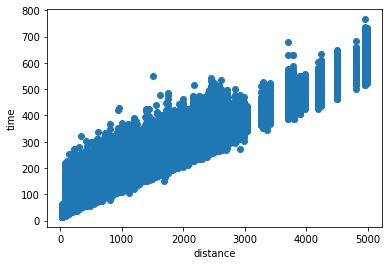

In [4]:
# wykres dla czasu od dystansu
plt.scatter(flights['DISTANCE'],flights['ELAPSED_TIME'])
plt.xlabel("distance")
plt.ylabel("time")

In [5]:
# trenowanie liniowego modelu
X = pd.DataFrame(flights['DISTANCE'])
y = pd.DataFrame(flights['ELAPSED_TIME'])
model = linear_model.LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:])
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
    
print(scores)

[0.9471727208387726, 0.9472864979854528, 0.9469934693156252]


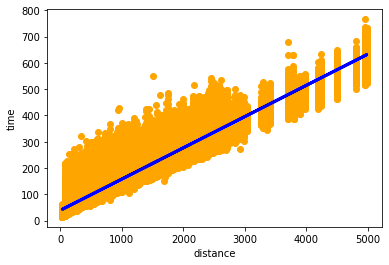

In [6]:
# drukowanie liniowego modelu
pred = model.predict(X)

plt.scatter(flights['DISTANCE'],flights['ELAPSED_TIME'], color='orange')
plt.xlabel("distance")
plt.ylabel("time")
plt.plot(flights['DISTANCE'], pred, color="blue", linewidth=3)

plt.show()

In [7]:
# model liniowy przejrzysty
X = pd.DataFrame(flights['DISTANCE'])
y = pd.DataFrame(flights['ELAPSED_TIME'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True)
model = linear_model.LinearRegression()
model.fit(X_train,y_train)
print(model.score(X_test,y_test))

0.9466776425360489


In [8]:
mean_squared_error(y_test,model.predict(X_test))

293.57404986443373

In [9]:
#n['dif'] = n.apply(lambda x: x['real']-x['pred'], axis=1)

In [10]:
#plt.scatter(X_test['DISTANCE'],n['dif'])
#plt.xlabel("distance")
#plt.ylabel("delay")
#plt.title("Różnica między realnym czasem lotu, a przewidywanym dla zbioru testowego")

In [11]:
print(model.predict(X_test[:5]))
print(y_test[:5])
print(mean_squared_error((y_test[:5]),(model.predict(X_test[:5]))))

[[ 96.68184434]
 [ 67.10461135]
 [126.25907733]
 [ 83.97194904]
 [150.37224317]]
         ELAPSED_TIME
612621           97.0
4872275          69.0
173463          123.0
2412130          87.0
3326826         184.0
230.86208557270183


## Porówanie SVR z XGBoost

In [12]:
flg = flights = pd.read_csv('data/flights_weather.csv', low_memory=False)

In [13]:
fl = flg[:50000]

In [14]:
#xgdboost wind, 
X=fl[['DISTANCE','Wind_Speed_dep','Wind_Speed_arv','Visibility_dep','Visibility_arv']]
y=fl['ELAPSED_TIME']
X['Wind_Speed_dep'] = X['Wind_Speed_dep'].fillna(0)
X['Wind_Speed_arv'] = X['Wind_Speed_arv'].fillna(0)
X['Visibility_dep'] = X['Visibility_dep'].fillna(0)
X['Visibility_arv'] = X['Visibility_arv'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True)

/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [15]:
model = xgboost.XGBRegressor()
model.fit(X_train,y_train)
print(model.score(X_test,y_test))

0.948043574872324


In [10]:
mean_squared_error(y_test,model.predict(X_test))

296.00040248062004

In [19]:
model_svr = SVR()
model_svr.fit(X_train, y_train)

SVR()

In [20]:
mean_squared_error(y_test,model.predict(X_test))

323.355017342967

# use of xgdboost

In [ ]:
# src: https://machinelearningmastery.com/xgboost-for-regression/

In [3]:
flg = flights = pd.read_csv('data/flights_weather.csv', low_memory=False)

In [23]:
#fl = flg[:3000]
fl = flg

In [24]:
fl.shape

(5184361, 51)

In [14]:
flg.head(5)
print(flg.columns)

Index(['DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON',
       'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'Temperature_dep',
       'Dew_Point_dep', 'Relative_Humidity_dep', 'Wind_Speed_dep',
       'Wind_Gust_dep', 'WindDirection_dep', 'Precipitation_dep',
       'Snow_Depth_dep', 'Visibility_dep', 'Cloud_Cover_dep',
       'Sea_Lv_Pressure_dep', 'Weather_Type_dep', 'Conditions_dep',
       'Temperature_arv', 'Dew_Point_arv', 'Relative_Humidity_arv',
       'Wind_Speed_arv', 'Wind_Gust_arv', 'WindDirection_arv',
       'Precipitation_arv', 'Snow_Depth_arv', 'Visibility_arv',
       'Cloud_Cover_arv', 'Sea_Lv_Pressure_arv', 'Weather_

In [25]:
# xgdboost for distance only
X=pd.DataFrame(fl['DISTANCE'])
y=pd.DataFrame(fl['ELAPSED_TIME'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True)

In [26]:
model = xgboost.XGBRegressor()
model.fit(X_train,y_train)
print(model.score(X_test,y_test))
print(mean_squared_error(y_test,model.predict(X_test)))

0.94105691651192
324.29891407479784


In [27]:
#xgdboost for distance and wind
X=fl[['DISTANCE','Wind_Speed_dep','Wind_Speed_arv']]
y=fl['ELAPSED_TIME']
X['Wind_Speed_dep'] = X['Wind_Speed_dep'].fillna(0)
X['Wind_Speed_arv'] = X['Wind_Speed_arv'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True)

/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [28]:
model = xgboost.XGBRegressor()
model.fit(X_train,y_train)
print(model.score(X_test,y_test))
print(mean_squared_error(y_test,model.predict(X_test)))

0.9431753165289474
313.24351081462953


In [29]:
#xgdboost wind, 
X=fl[['DISTANCE','Wind_Speed_dep','Wind_Speed_arv','Visibility_dep','Visibility_arv']]
y=fl['ELAPSED_TIME']
X['Wind_Speed_dep'] = X['Wind_Speed_dep'].fillna(0)
X['Wind_Speed_arv'] = X['Wind_Speed_arv'].fillna(0)
X['Visibility_dep'] = X['Visibility_dep'].fillna(0)
X['Visibility_arv'] = X['Visibility_arv'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True)

/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [30]:
model = xgboost.XGBRegressor()
model.fit(X_train,y_train)
print('Wind, vis score: %.5f' % (model.score(X_test,y_test)))
print(mean_squared_error(y_test,model.predict(X_test)))

Wind, vis score: 0.94694
290.7249230888711


In [31]:
#xgdboost wind, vis, cloud
X=fl[['DISTANCE','Wind_Speed_dep','Wind_Speed_arv','Visibility_dep','Visibility_arv',
      'Cloud_Cover_dep','Cloud_Cover_arv']]
y=fl['ELAPSED_TIME']
X['Wind_Speed_dep'] = X['Wind_Speed_dep'].fillna(0)
X['Wind_Speed_arv'] = X['Wind_Speed_arv'].fillna(0)
X['Visibility_dep'] = X['Visibility_dep'].fillna(0)
X['Visibility_arv'] = X['Visibility_arv'].fillna(0)
X['Cloud_Cover_dep'] = X['Cloud_Cover_dep'].fillna(0)
X['Cloud_Cover_arv'] = X['Cloud_Cover_arv'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True)

/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [32]:
model = xgboost.XGBRegressor()
model.fit(X_train,y_train)
print('Wind, vis, cloud score: %.5f' % (model.score(X_test,y_test)))
print(mean_squared_error(y_test,model.predict(X_test)))

Wind, vis, cloud score: 0.95116
268.8529663656065


In [33]:
#xgdboost wind, vis, cloud, perp
X=fl[['DISTANCE','Wind_Speed_dep','Wind_Speed_arv','Visibility_dep','Visibility_arv',
      'Cloud_Cover_dep','Cloud_Cover_arv',
     'Precipitation_dep','Precipitation_arv','Snow_Depth_dep','Snow_Depth_arv']]
y=fl['ELAPSED_TIME']
X['Wind_Speed_dep'] = X['Wind_Speed_dep'].fillna(0)
X['Wind_Speed_arv'] = X['Wind_Speed_arv'].fillna(0)
X['Visibility_dep'] = X['Visibility_dep'].fillna(0)
X['Visibility_arv'] = X['Visibility_arv'].fillna(0)
X['Cloud_Cover_dep'] = X['Cloud_Cover_dep'].fillna(0)
X['Cloud_Cover_arv'] = X['Cloud_Cover_arv'].fillna(0)
X['Precipitation_dep'] = X['Precipitation_dep'].fillna(0)
X['Precipitation_arv'] = X['Precipitation_arv'].fillna(0)
X['Snow_Depth_dep'] = X['Snow_Depth_dep'].fillna(0)
X['Snow_Depth_arv'] = X['Snow_Depth_arv'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True)

/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [34]:
model = xgboost.XGBRegressor()
model.fit(X_train,y_train)
print('Wind, vis, cloud, perc score: %.5f' % (model.score(X_test,y_test)))
print(mean_squared_error(y_test,model.predict(X_test)))

Wind, vis, cloud, perc score: 0.95328
255.59424607233663


In [35]:
#xgdboost wind, vis, cloud
X=fl[['DISTANCE','Wind_Speed_dep','Wind_Speed_arv','Visibility_dep','Visibility_arv',
      'Cloud_Cover_dep','Cloud_Cover_arv',
      'Temperature_arv','Temperature_dep']]
y=fl['ELAPSED_TIME']
X['Wind_Speed_dep'] = X['Wind_Speed_dep'].fillna(0)
X['Wind_Speed_arv'] = X['Wind_Speed_arv'].fillna(0)
X['Visibility_dep'] = X['Visibility_dep'].fillna(0)
X['Visibility_arv'] = X['Visibility_arv'].fillna(0)
X['Cloud_Cover_dep'] = X['Cloud_Cover_dep'].fillna(0)
X['Cloud_Cover_arv'] = X['Cloud_Cover_arv'].fillna(0)
X['Temperature_arv'] = X['Temperature_arv'].fillna(0)
X['Temperature_dep'] = X['Temperature_dep'].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=True)

/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/dominik/.conda/envs/aviation/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [36]:
model = xgboost.XGBRegressor()
model.fit(X_train,y_train)
print('Wind, vis, cloud, temp score: %.5f' % (model.score(X_test,y_test)))
print(mean_squared_error(y_test,model.predict(X_test)))

Wind, vis, cloud, temp score: 0.95460
251.5927658603692


### Średnia różnica

In [37]:
y_prim = y_test.reset_index(drop=True)
n = pd.DataFrame()
n['pred']=model.predict(X_test)
n['real']=y_prim
print(n)

              pred   real
0       118.978149  114.0
1       135.140884  128.0
2        48.109066   57.0
3       107.698898   99.0
4        75.656746   63.0
...            ...    ...
103683   86.489594   77.0
103684  138.742157  154.0
103685  365.214539  379.0
103686  170.403976  169.0
103687  235.918976  238.0

[103688 rows x 2 columns]


In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(n)

              pred   real
0       118.978149  114.0
1       135.140884  128.0
2        48.109066   57.0
3       107.698898   99.0
4        75.656746   63.0
5        74.755295   71.0
6       249.995651  232.0
7        72.355247   69.0
8       130.507996  145.0
9       156.682404  136.0
10      153.163330  152.0
11      211.071106  215.0
12      173.670044  174.0
13       99.647858   87.0
14      159.289505  144.0
15       56.938614   55.0
16      120.448517  122.0
17       91.617104   78.0
18      153.901398  176.0
19      109.331696  120.0
20      124.093666  147.0
21       92.527069   92.0
22       54.257137   64.0
23       71.615440   70.0
24       53.579407   54.0
25      325.222778  380.0
26      133.744797  124.0
27       84.441025  100.0
28       56.390087   91.0
29      298.121765  292.0
30      363.959961  312.0
31      245.830078  221.0
32       82.649185   87.0
33      162.451202  150.0
34       87.999115   94.0
35       69.945518   70.0
36      155.987930  156.0
37      200.

In [39]:
mean =0
num =0
for (index, y), (index,x) in zip(n.iterrows(),X_test.iterrows()):
    mean += abs(y['pred']-y['real'])
    num+=1
print(mean/num)

11.126364061396648


In [40]:
sum1=0
for index, y in n.iterrows():
    sum1+=y['real']
print(sum1/num)

137.34273011341716


In [41]:
n['dif'] = n.apply(lambda x: x['real']-x['pred'], axis=1)

Text(0.5, 1.0, 'Różnica między realnym czasem lotu, a przewidywanym dla zbioru testowego')

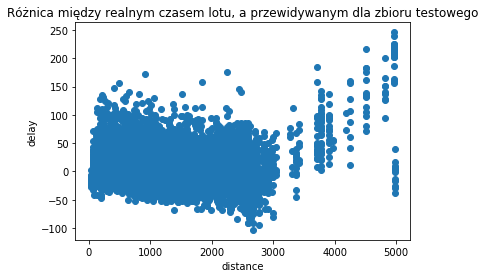

In [42]:
plt.scatter(X_test['DISTANCE'],n['dif'])
plt.xlabel("distance")
plt.ylabel("delay")
plt.title("Różnica między realnym czasem lotu, a przewidywanym dla zbioru testowego")